**Thinking1：电商定向广告和搜索广告有怎样的区别，算法模型是否有差别**

- 定向广告：
  - 用户没有明显的意图
  - 主要根据用户的历史行为做推荐
- 搜索广告：
  - 目标明确
  - 主要根据搜索关键词做推荐

**Thinking2：定向广告都有哪些常见的使用模型，包括Attention机制模型**

- 传统机器学习模型：LR、MLR  
- 深度学习模型：DNN  
- 带Attention机制的深度学习模型：DIN、DIEN、DSIN  

**Thinking3：DIN中的Attention机制思想和原理是怎样的**

- 出发点：用户可以对多种类别的商品感兴趣，而类别之间的关联性不大，说明只有**一部分历史行为**对用户当前的点击预测有帮助。这里的**一部分历史行为**就是Attention机制所要处理的。  
- 原理：把用户历史行为特征进行embedding，通过Attention Unit对每个历史行为特征赋予不同的权重。

**Thinking4：DIEN相比于DIN有哪些创新**

DIEN考虑理兴趣的演化过程，不再是把每个兴趣作为不相关的独立输入。用了GRU提取兴趣的演化特征。

**Thinking5：DSIN关于Session的洞察是怎样的，如何对Session兴趣进行表达**

做了一个session切割，每30分钟进行session切分，和airbnb的处理方式一样。

**Thinking6：如果你来设计淘宝定向广告，会有哪些future work（即下一个阶段的idea）**

1. 类似airbnb的方式，对用户进行分类，然后进行type embedding，更好地提取用户和商品特征。
2. DSIN中Session Interest Interacting Layer模块使用的是Bi-LSTM，是否可以使用Transformer？
3. 按潜在需求推荐商品，比如买了A商品，可以推荐出现在同一使用场景中的B商品。
  - 个人使用天猫，感觉买完A商品，更多的推荐是和A功能类似的商品，而非潜在的需求。（有时候还是更便宜的同类商品...)

**Action1：数据集：天猫用户复购预测**
https://tianchi.aliyun.com/competition/entrance/231576/introduction

## XGBoost模型

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# 读取数据
path = 'data/data_format1/'
user_info = pd.read_csv(path+'user_info.csv')
user_log = pd.read_csv(path+'user_log.csv', dtype={'time_stamp':'str'})
train_data = pd.read_csv(path+'train.csv')
test_data = pd.read_csv(path+'test.csv')

# 数据处理
user_log['brand_id'].fillna(0, inplace=True)
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)
# label encoder
id_cols = ['user_id', 'item_id', 'cat_id', 'merchant_id', 'brand_id']
for col in id_cols:
    user_log[col] = user_log[col].astype(np.int32)
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%m%d')
user_log['action_type'] = user_log['action_type'].astype(np.uint8)

In [ ]:
# 特征工程（用函数封装，易读）
def features(user_log, train_data, feat_type):
    if feat_type=='user':
        # user_log groupby
        groups_log = user_log.groupby('user_id')
        id_cols = ['item_id', 'cat_id', 'merchant_id', 'brand_id', 'time_stamp']
        prefix = 'u_'

    elif feat_type=='merchant':
        groups_log = user_log.groupby('merchant_id')
        id_cols = ['item_id', 'cat_id', 'user_id', 'brand_id', 'time_stamp']
        prefix = 'm_'

    elif feat_type=='combine':
        groups_log = user_log.groupby(['user_id','merchant_id'])
        id_cols = ['item_id', 'cat_id', 'brand_id', 'time_stamp']
        prefix = 'um_'

    else:
        raise ValueError('illegal parameter feat_type')

    '''user log related'''
    # 交互行为数量
    feats = pd.DataFrame(groups_log.size()).rename(columns={0:'action_num'})
    for col in id_cols:
        tmp = groups_log[col].agg({'nunique'})
        max_num = tmp['nunique'].max()
        if max_num<=255:
            tmp = tmp.astype(np.uint8)
        elif max_num<=65535:
            tmp = tmp.astype(np.uint16)
        else:
            tmp = tmp.astype(np.uint32)
        feats[col.replace('_id','')+'_num'] = tmp
    # 交互时间间隔
    tmp = groups_log['time_stamp'].agg([('first_time','min'), ('last_time','max')])
    feats['time_span'] = (tmp['last_time']-tmp['first_time']).dt.days.astype(np.uint8)
    # 各操作类型数量
    tmp = groups_log['action_type'].value_counts().unstack()
    tmp.columns = ['action_'+str(col) for col in tmp.columns]
    feats[tmp.columns] = tmp
    # 购买点击比
    feats['buy_click_rate'] = feats['action_2']/feats['action_0']

    # rename every column
    feats.columns = [prefix+col for col in feats.columns]
    feats.reset_index(inplace=True)

    if feat_type=='merchant':
        # 统计复购数量、比例
        groups_rebuy = train_data.groupby(['merchant_id'])
        tmp = groups_rebuy['label'].agg({'sum', 'mean'})
        tmp.columns = [prefix+'rebuy_num', prefix+'rebuy_rate']
        feats = feats.merge(tmp, on='merchant_id', how='left')

    feats.fillna(0, inplace=True)

    return feats

In [ ]:
matrix = pd.concat([train_data, test_data.drop(columns=['prob'])], ignore_index=True, sort=False)
matrix = matrix.merge(user_info, on='user_id', how='left')
# 1 for <18; 2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50; 0 and NULL for unknown
matrix['age_range'].fillna(0, inplace=True)
# 0:female, 1:male, 2:unknown
matrix['gender'].fillna(2, inplace=True)
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
# matrix['label'] = matrix['label'].astype('int')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int16')

# 用户特征
user_feats = features(user_log, train_data, 'user')
matrix = matrix.merge(user_feats, on='user_id', how='left')
# 商家特征
merchant_feats = features(user_log, train_data, 'merchant')
matrix = matrix.merge(merchant_feats, on='merchant_id', how='left')
# 用户*商家特征
user_merchant_feats = features(user_log, train_data, 'combine')
matrix = matrix.merge(user_merchant_feats, on=['user_id','merchant_id'], how='left')

In [ ]:
# 训练数据、测试数据分割
train_data = matrix[matrix['label'].notna()]
test_data = matrix[matrix['label'].isna()]

train_X = train_data.drop(columns=['label'])
train_y = train_data['label']

In [18]:
# 使用xgb进行5折交叉验证
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

split = StratifiedKFold(n_splits=5, shuffle=True)

models = []
for train_idx, valid_idx in split.split(train_X, train_y):
    # 将训练集进行切分，20%用于验证
    X_train, X_valid = train_X.iloc[train_idx], train_X.iloc[valid_idx]
    y_train, y_valid = train_y[train_idx], train_y[valid_idx]
    # 正负样本不平衡，用样本权重进行平衡
    pos_weight = y_train.size/y_train.sum()
    # 使用XGBoost
    model = xgb.XGBClassifier(
        max_depth=6, n_estimators=1000, learning_rate=0.01,
        min_child_weight=300, colsample_bytree=0.8, subsample=0.8, gamma=2.5,
        scale_pos_weight=pos_weight, seed=42)
    model.fit(
        X_train, y_train,
        eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=True,
        #早停法，如果auc在10epoch没有进步就stop
        early_stopping_rounds=100)
    models.append(model)

[0]	validation_0-auc:0.69812	validation_1-auc:0.69076
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.69968	validation_1-auc:0.69035
[2]	validation_0-auc:0.70579	validation_1-auc:0.69501
[3]	validation_0-auc:0.70720	validation_1-auc:0.69748
[4]	validation_0-auc:0.70850	validation_1-auc:0.69840
[5]	validation_0-auc:0.71188	validation_1-auc:0.70144
[6]	validation_0-auc:0.71167	validation_1-auc:0.70168
[7]	validation_0-auc:0.71135	validation_1-auc:0.70171
[8]	validation_0-auc:0.71119	validation_1-auc:0.70163
[9]	validation_0-auc:0.71085	validation_1-auc:0.70139
[10]	validation_0-auc:0.71112	validation_1-auc:0.70134
[11]	validation_0-auc:0.71295	validation_1-auc:0.70338
[12]	validation_0-auc:0.71309	validation_1-auc:0.70353
[13]	validation_0-auc:0.71284	validation_1-auc:0.70322
[14]	validation_0-auc:0.71301	validation_1-auc:0.70330
[15]	validation_0-auc:0.713

In [ ]:
probs = []
for model in models:
    probs.append(model.predict_proba(test_data))
prob = np.mean(np.array(probs), axis=0)

In [ ]:
sub_path = 'submissions/'
submission = pd.read_csv(path+'test.csv')
submission['prob'] = pd.Series(prob[:,1])
submission.to_csv(sub_path+'prediction_xgb_days_depth_3_lr_001_fold_5_gamma_2_5.csv', index=False)

**XGBoost分数：0.6896**

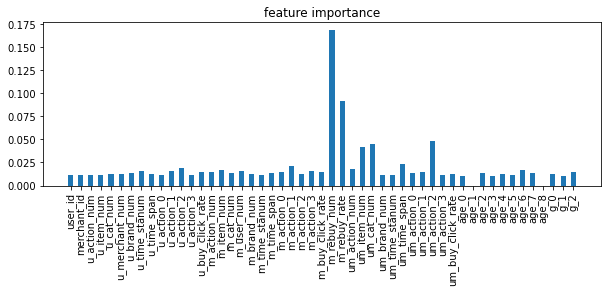

In [12]:
num_feats = len(train_X.columns)
plt.figure(figsize=(10,3))
plt.bar(np.arange(num_feats),model.feature_importances_, width=0.5)
plt.xticks(np.arange(num_feats), train_X.columns, rotation=90)
plt.title('feature importance')
plt.show()

**比较重要的特征为：**
- 以用户商家分组的购买行为数量、以用户商家分组的不同商品类别数量、以用户商家分组的不同商品数量；
- 商家的复购数量，商家被添加到购物车的行为数量

## DIN模型

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from deepctr.models import DIN
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, DenseFeat,get_feature_names

In [ ]:
'''接着上面xgb的特征工程，这里就不重复写了'''
'''加入历史行为信息的特征工程，时间关系只加入了用户浏览商家的历史'''
# history featurs
history_cols = ['merchant_id']
# add mask for history features
user_log[history_cols]=user_log[history_cols].applymap(lambda x: x+1)
# 用户行为sequence
# 把user_log里同user的这些数据合并成一个list
temp=pd.DataFrame(user_log.groupby('user_id')[history_cols].agg(lambda x:list(x)))
'''M取太长内存就爆了...'''
M=50 # 截取最近的M个动作，不足用0填充
temp = temp.applymap(lambda x:np.array(x+[0]*(M-len(x)))[:M])
# 列名称改成hist_merchant_id 和 hist_action_type
temp.columns=['hist_'+col for col in temp.columns]

matrix = matrix.merge(temp, on=['user_id'], how='left')

In [ ]:
# 得到DIN所需的特征输入
def get_feature_columns(matrix):
    feature_columns = []
    
    # sparse feats: dictionary name:embedding dimmesion
    sparse_feats = ['user_id', 'merchant_id', 'age_range', 'gender']
    embd_size = {'user_id':8, 'merchant_id':4, 'age_range':2, 'gender':2}
    vocb_size = {'user_id':424170, 'merchant_id':4995+1, 'age_range':9, 'gender':3}
    for name  in sparse_feats:
        feature_columns.append(
            SparseFeat(name, vocabulary_size=vocb_size[name], embedding_dim=embd_size[name]))

    # behavior feats
    behavior_feats = ['merchant_id']
    for name in behavior_feats:
        '''这是DIN规定的历史行为的名称（必须加hist_前缀），感觉很奇怪，为什么不能自己定义？（可能是我没看懂？）'''
        hist_name = 'hist_' + name
        feature_columns.append(
            VarLenSparseFeat(
                SparseFeat(hist_name, vocabulary_size=vocb_size[name], 
                           embedding_dim=embd_size[name], embedding_name=name),
                maxlen=50))
    # dense features
    dense_feats = []
    for name in matrix.drop(columns=['label']).columns:
        if name not in sparse_feats and name not in map(lambda x: 'hist_'+x, behavior_feats):
            feature_columns.append(DenseFeat(name))
            dense_feats.append(name)         
    
    return feature_columns, sparse_feats, behavior_feats, dense_feats

# 获取各种特征名
feature_columns, sparse_feats, behavior_feats, dense_feats = get_feature_columns(matrix)

In [ ]:
# DIN输入需要字典格式，在这里转换
def get_din_input(X, feature_columns, behavior_feats):
    X = {name:X[name].values for name in get_feature_names(feature_columns)}
    '''历史行为需要转换成二维numpy array'''
    for name in behavior_feats: 
        hist_name = 'hist_'+name
        X[hist_name] = np.stack(X[hist_name])
    return X

In [ ]:
# 对dense feature归一化
ss = StandardScaler()
matrix[dense_feats] = ss.fit_transform(matrix[dense_feats])  

# 训练数据、测试数据分割
train_data = matrix[matrix['label'].notna()]
test_data = matrix[matrix['label'].isna()]

train_X = train_data.drop(columns=['label'])
train_y = train_data['label']

In [ ]:
# 5 fold交叉验证
sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
# 存储五个模型
models = []
for train_idx, valid_idx in sss.split(train_X, train_y):
    X_train, X_valid = train_X.iloc[train_idx], train_X.iloc[valid_idx]
    y_train, y_valid = train_y[train_idx], train_y[valid_idx]
    # conver to DIN input format
    X_train = get_din_input(X_train, feature_columns, behavior_feats)
    X_valid = get_din_input(X_valid, feature_columns, behavior_feats)
    
    model = DIN(feature_columns, behavior_feats, l2_reg_embedding=1e-3, dnn_dropout=0.8)
    callback = EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True)
    model.compile('adam', 'binary_crossentropy', metrics=['AUC'])
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[callback],
                        verbose=1, epochs=10, batch_size=256*4, shuffle=True,
                        class_weight={0:0.06, 1:0.94}
                       )
    models.append(model)

In [ ]:
# 转换输入格式
test_X = get_din_input(test_data, feature_columns, behavior_feats)
probs = []
for model in models:
    probs.append(model.predict(test_X))

prob = np.mean(probs, axis=0)

In [ ]:
submission = pd.read_csv(path+'test.csv')
submission['prob'] = prob
sub_path = 'submissions/'
submission.to_csv(sub_path+'prediction_din.csv', index=False)

**DIN分数：0.6872**  
1. DIN容易过拟合，需要调参，不过没时间了。
2. 这里的Dense特征感觉给得太多了，可以把xgb中比较重要的特征输进去